In [84]:
import os, logging, csv

import numpy as np
import pandas as pd
from specdal import Collection, Spectrum, read

from matplotlib import pyplot as plt
import seaborn as sns

### Apply Jump Correction to Spectral Data

In [10]:
# Set up the logger
# NOTE: CRITICAL > ERROR > WARNING > INFO > DEBUG
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s')
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
 
bool_saveCsv = True
bool_saveFig = False
 
# set path
wd = r'/Users/ryangeygan/Graphyte/Projects/project_alpha/data'
logger.debug(f'wd: {wd}')
 
outputDir = os.path.join(wd, "spectral_data")
   
c = Collection(name = 'Sample data', directory = f'{wd}/spectral_data/asd_carbon_blocks')
c.jump_correct(splices=[1000, 1800], reference = 1)
c.data.T.to_csv(f'{outputDir}/jump_corrected.csv')

2024-06-27 15:04:24,033 - DEBUG - wd: /Users/ryangeygan/Graphyte/Projects/project_alpha/data


In [30]:
jc = pd.read_csv('/Users/ryangeygan/Graphyte/Projects/project_alpha/data/spectral_data/jump_corrected.csv')
#Rename the sample id col
jc = jc.rename(mapper = {'Unnamed: 0':'sample_id'}, axis=1)
#Remove white refs and clean sample ids to join to carbon data
def clean_data(df):
    """
    Clean the data by removing rows with sample_id ending in '_00000' and removing 
    the last six characters from the remaining sample_ids.
    """
    # Remove rows where sample_id ends with '_00000'
    df = df[~df['sample_id'].str.endswith('_00000')]

    # Remove the last six characters from the remaining sample_ids
    df['sample_id'] = df['sample_id'].str[:-6]

    return df

jc = clean_data(jc)

/var/folders/wq/8mxmhthx1qjg6pq5jr3045k40000gn/T/ipykernel_70680/747980206.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sample_id'] = df['sample_id'].str[:-6]


### Apply Unit Vector Normalization

In [133]:
def normalize_series(series):
    """
    Normalize a pandas Series to the range [0, 1].
    """
    min_val = series.min()
    max_val = series.max()
    return (series - min_val) / (max_val - min_val)

def normalize_rows(df):
    """
    Normalize each row in a DataFrame (excluding the first column) to the range [0, 1].
    """
    # Keep the first column unchanged
    sample_ids = df.iloc[:, 0]
    
    # Normalize each row excluding the first column
    normalized_data = df.iloc[:, 1:].apply(normalize_series, axis=1)
    
    # Concatenate the sample IDs with the normalized data
    normalized_df = pd.concat([sample_ids, normalized_data], axis=1)
    
    return normalized_df

In [134]:
normalized = normalize_rows(jc)

In [33]:
normalized.head()

,sample_id,350.0,351.0,352.0,353.0,354.0,355.0,356.0,357.0,358.0,359.0,360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,370.0,371.0,372.0,373.0,374.0,375.0,376.0,377.0,378.0,379.0,380.0,381.0,382.0,383.0,384.0,385.0,386.0,387.0,388.0,...,2461.0,2462.0,2463.0,2464.0,2465.0,2466.0,2467.0,2468.0,2469.0,2470.0,2471.0,2472.0,2473.0,2474.0,2475.0,2476.0,2477.0,2478.0,2479.0,2480.0,2481.0,2482.0,2483.0,2484.0,2485.0,2486.0,2487.0,2488.0,2489.0,2490.0,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0
1,H_B_1_1,0.001290,0.003771,0.004357,0.003196,0.003053,0.001618,0.000000,0.001322,0.002621,0.002543,0.000822,0.000960,0.002808,0.005118,0.004915,0.003433,0.001655,0.000405,0.002369,0.005178,0.005100,0.004423,0.003625,0.003271,0.004985,0.007755,0.010095,0.009712,0.007830,0.006141,0.006591,0.008647,0.009295,0.007183,0.009564,0.010363,0.008120,0.009874,0.011149,...,0.664486,0.661895,0.654962,0.650498,0.645976,0.639532,0.640243,0.641540,0.639115,0.644071,0.651205,0.640036,0.634780,0.629975,0.624892,0.617259,0.618525,0.631955,0.630293,0.622484,0.624279,0.620452,0.616947,0.627659,0.627966,0.607168,0.607217,0.632494,0.629036,0.611571,0.608564,0.590865,0.585392,0.605785,0.608789,0.598707,0.595774,0.595614,0.604166,0.605530
2,H_B_1_1,0.001560,0.000000,0.001694,0.006282,0.005403,0.004950,0.005306,0.003802,0.003536,0.004346,0.005342,0.006246,0.007416,0.008339,0.005761,0.004936,0.006157,0.005211,0.005879,0.008056,0.010047,0.007589,0.006107,0.009066,0.009921,0.011036,0.012528,0.011318,0.011398,0.011808,0.009816,0.010581,0.011675,0.010888,0.012870,0.013844,0.012939,0.014832,0.014618,...,0.651983,0.645612,0.648355,0.645380,0.641594,0.637457,0.632744,0.634973,0.640753,0.641635,0.637064,0.626946,0.622152,0.624284,0.622301,0.614220,0.613500,0.624465,0.623179,0.612911,0.612702,0.610255,0.604604,0.604525,0.611507,0.618331,0.616752,0.622849,0.624910,0.613275,0.605079,0.595926,0.601788,0.618816,0.617312,0.617006,0.622109,0.612403,0.624563,0.634657
3,H_B_1_1,0.001980,0.000000,0.000664,0.001435,0.001776,0.001974,0.002264,0.002891,0.002723,0.002632,0.003422,0.001853,0.002921,0.007609,0.006141,0.005251,0.005808,0.003476,0.004185,0.006115,0.005422,0.005714,0.006139,0.005769,0.004821,0.006669,0.010202,0.007884,0.008790,0.011106,0.008883,0.008841,0.010409,0.011711,0.011181,0.010317,0.010318,0.012047,0.013773,...,0.704982,0.696641,0.695338,0.690027,0.686798,0.686694,0.688108,0.691386,0.692218,0.696228,0.701486,0.688910,0.680822,0.676793,0.674535,0.668951,0.667818,0.676755,0.675549,0.668396,0.667927,0.661195,0.662445,0.682910,0.683487,0.670033,0.674707,0.680610,0.676060,0.685564,0.677352,0.630811,0.630978,0.665693,0.662984,0.657201,0.663198,0.649565,0.663966,0.686939
4,H_B_1_1,0.000000,0.002115,0.006837,0.010714,0.007851,0.006216,0.006521,0.005332,0.006026,0.007828,0.008852,0.005938,0.005203,0.008953,0.009799,0.008675,0.007019,0.007018,0.008972,0.011014,0.010735,0.009165,0.009269,0.011976,0.011106,0.010999,0.012437,0.011378,0.012151,0.013597,0.012476,0.012044,0.012458,0.013337,0.014809,0.015171,0.014426,0.015756,0.015423,...,0.659965,0.659461,0.660564,0.659107,0.663705,0.658221,0.649721,0.656553,0.661221,0.657438,0.653206,0.638528,0.636529,0.657870,0.659495,0.647984,0.647547,0.647119,0.637958,0.624966,0.626366,0.628410,0.624736,0.636915,0.640443,0.621298,0.617365,0.634085,0.633423,0.622634,0.616124,0.599253,0.597068,0.612896,0.608417,0.588161,0.598004,0.619274,0.639816,0.654712
5,H_B_1_1,0.000584,0.002044,0.003887,0.005566,0.006811,0.003805,0.000000,0.003353,0.004299,0.003717,0.004045,0.000762,0.000056,0.003999,0.003676,0.003340,0.003830,0.003073,0.003983,0.005775,0.006345,0.003461,0.002911,0.007329,0.006285,0.005775,0.007435,0.007287,0.007199,0.006888,0.005595,0.008463,0.010934,0.009217,0.009810,0.010109,0.009598,0.012223,0.012705,...,0.692652,0.690747,0.680957,0.678198,0.674814,0.663248,0.662905,0.664019,0.656407,0.654414,0.650918,0.648539,0.647835,0.651819,0.656069,0.662461,0.662905,0.659412,0.658647,0.657267,0.649506,0.632897,0.637320

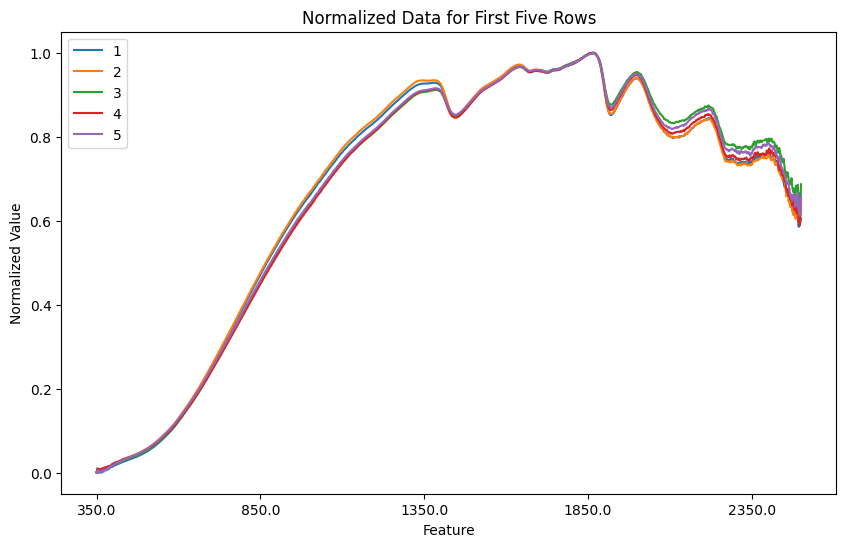

In [34]:
plot_data = normalized.iloc[:5, 1:]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
plot_data.T.plot(ax=ax)
ax.set_title('Normalized Data for First Five Rows')
ax.set_xlabel('Feature')
ax.set_ylabel('Normalized Value')
plt.show()

In [144]:
def average_by_first_part(df):
    """
    Average the row data for every sample id that has a matching string 
    in the first position of a sample id that is delimited by underscores.
    """
    # Extract the first part of the sample_id
    df['b_type'] = df['sample_id'].str.split('_').str[0]
    
    # Select only the numeric columns for averaging
    numeric_df = df.drop(columns=['sample_id', 'b_type'])
    
    # Group by the first part and compute the mean for each group
    averaged_numeric_df = numeric_df.groupby(df['b_type']).mean().reset_index()
    
    return averaged_numeric_df

avg_spec = average_by_first_part(normalized)

2024-06-28 10:53:58,684 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-28 10:53:58,688 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-28 10:53:58,692 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-28 10:53:58,695 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-06-28 10:53:58,701 - INFO - Using categorical units to plot a list of strings that are all parsable as 

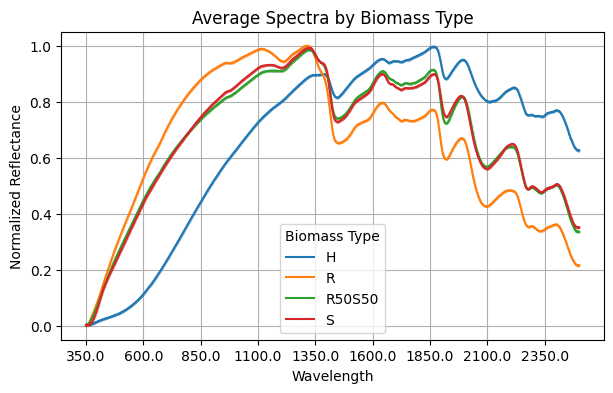

In [152]:
plt.figure(figsize=(7, 4))  # Adjust size as needed

# Iterate over each row
for index, row in avg_spec.iterrows():
    # Extract x values (column names except 'b_type')
    x_values = avg_spec.columns[1:]
    
    # Plot y values (row values except 'b_type')
    y_values = row[1:]
    
    # Plot each row
    plt.plot(x_values, y_values, marker='o', markersize=0.1, label=row['b_type'])

# Set x-axis tick positions and labels to show every 100th tick
ticks = range(0, len(x_values), 250)
plt.xticks(ticks, [x_values[i] for i in ticks])

plt.xlabel('Wavelength')
plt.ylabel('Normalized Reflectance')
plt.title('Average Spectra by Biomass Type')
plt.legend(title='Biomass Type')
plt.grid(True)
plt.show()

In [94]:
carbon_data = pd.read_csv('/Users/ryangeygan/Graphyte/Projects/project_alpha/data/elemental_analysis_data.csv')

In [95]:
carbon_data.head()

,time_collected,biomass_type,processing_type,batch_number,subsample_id,measurement_type,run_id,carbon_content,moisture_content_at_facility,moisture_content_at_spec_lab,block_dry_weight,block_quality,sample_id,Notes,Unnamed: 14
0,6_18_24_9,H,GD,1,1,EA,1,0.4966,0.08,NaN,NaN,NaN,H_GD_1_1_EA_1,NaN,NaN
1,6_18_24_9,H,GD,1,2,EA,1,0.4942,0.08,NaN,NaN,NaN,H_GD_1_2_EA_1,NaN,NaN
2,6_18_24_9,H,GD,1,3,EA,1,0.4835,0.08,NaN,NaN,NaN,H_GD_1_3_EA_1,NaN,NaN
3,6_18_24_9,H,GD,1,4,EA,1,0.4854,0.08,NaN,NaN,NaN,H_GD_1_4_EA_1,NaN,NaN
4,6_18_24_9,H,GD,1,5,EA,1,0.4879,0.08,NaN,NaN,NaN,H_GD_1_5_EA_1,NaN,NaN


In [115]:
block_data = carbon_data[carbon_data.processing_type=='B'][[
    'sample_id', 'carbon_content', 'moisture_content_at_facility']].dropna()

block_data['sample_id'] = block_data.sample_id.apply(lambda x: x[:-5])

block_data['carbon_content_moisture_normalized'] = block_data.carbon_content / (1 - block_data.moisture_content_at_facility)

block_data = block_data.drop(columns='moisture_content_at_facility')

In [116]:
block_data

,sample_id,carbon_content,carbon_content_moisture_normalized
40,H_B_1_1,0.4753,0.516630
41,H_B_1_1,0.4924,0.535217
42,H_B_1_1,0.4904,0.533043
43,H_B_1_1,0.4929,0.535761
44,H_B_1_1,0.4892,0.531739
...,...,...,...
416,S_B_4_2,0.4862,0.528478
417,S_B_4_2,0.4828,0.524783
418,S_B_4_2,0.4833,0.525326
419,S_B_4_2,0.4857,0.527935


In [117]:
avg_block_data = block_data.groupby(['sample_id']).mean().reset_index()

In [122]:
avg_block_data

,sample_id,carbon_content,carbon_content_moisture_normalized
0,H_B_1_1,0.488040,0.530478
1,H_B_1_2,0.487920,0.530348
2,H_B_1_3,0.480260,0.522022
3,H_B_1_4,0.486220,0.528500
4,H_B_2_1,0.432680,0.470304
5,H_B_2_2,0.527840,0.573739
6,H_B_2_3,0.442100,0.480543
7,H_B_2_4,0.523200,0.568696
8,H_B_3_1,0.490140,0.532761
9,H_B_3_2,0.491980,0.534761


In [123]:
set(avg_block_data.sample_id) - set(normalized.sample_id)

{'S_B_4_3'}

In [124]:
set(normalized.sample_id) - set(avg_block_data.sample_id)

set()

In [136]:
model_training_data = pd.merge(normalized, avg_block_data, on = 'sample_id', how='inner')

In [158]:
model_training_data.head(12)

,sample_id,350.0,351.0,352.0,353.0,354.0,355.0,356.0,357.0,358.0,359.0,360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,370.0,371.0,372.0,373.0,374.0,375.0,376.0,377.0,378.0,379.0,380.0,381.0,382.0,383.0,384.0,385.0,386.0,387.0,388.0,...,2463.0,2464.0,2465.0,2466.0,2467.0,2468.0,2469.0,2470.0,2471.0,2472.0,2473.0,2474.0,2475.0,2476.0,2477.0,2478.0,2479.0,2480.0,2481.0,2482.0,2483.0,2484.0,2485.0,2486.0,2487.0,2488.0,2489.0,2490.0,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0,carbon_content,carbon_content_moisture_normalized
0,H_B_1_1,0.001290,0.003771,0.004357,0.003196,0.003053,0.001618,0.000000,0.001322,0.002621,0.002543,0.000822,0.000960,0.002808,0.005118,0.004915,0.003433,0.001655,0.000405,0.002369,0.005178,0.005100,0.004423,0.003625,0.003271,0.004985,0.007755,0.010095,0.009712,0.007830,0.006141,0.006591,0.008647,0.009295,0.007183,0.009564,0.010363,0.008120,0.009874,0.011149,...,0.654962,0.650498,0.645976,0.639532,0.640243,0.641540,0.639115,0.644071,0.651205,0.640036,0.634780,0.629975,0.624892,0.617259,0.618525,0.631955,0.630293,0.622484,0.624279,0.620452,0.616947,0.627659,0.627966,0.607168,0.607217,0.632494,0.629036,0.611571,0.608564,0.590865,0.585392,0.605785,0.608789,0.598707,0.595774,0.595614,0.604166,0.605530,0.48804,0.530478
1,H_B_1_1,0.001560,0.000000,0.001694,0.006282,0.005403,0.004950,0.005306,0.003802,0.003536,0.004346,0.005342,0.006246,0.007416,0.008339,0.005761,0.004936,0.006157,0.005211,0.005879,0.008056,0.010047,0.007589,0.006107,0.009066,0.009921,0.011036,0.012528,0.011318,0.011398,0.011808,0.009816,0.010581,0.011675,0.010888,0.012870,0.013844,0.012939,0.014832,0.014618,...,0.648355,0.645380,0.641594,0.637457,0.632744,0.634973,0.640753,0.641635,0.637064,0.626946,0.622152,0.624284,0.622301,0.614220,0.613500,0.624465,0.623179,0.612911,0.612702,0.610255,0.604604,0.604525,0.611507,0.618331,0.616752,0.622849,0.624910,0.613275,0.605079,0.595926,0.601788,0.618816,0.617312,0.617006,0.622109,0.612403,0.624563,0.634657,0.48804,0.530478
2,H_B_1_1,0.001980,0.000000,0.000664,0.001435,0.001776,0.001974,0.002264,0.002891,0.002723,0.002632,0.003422,0.001853,0.002921,0.007609,0.006141,0.005251,0.005808,0.003476,0.004185,0.006115,0.005422,0.005714,0.006139,0.005769,0.004821,0.006669,0.010202,0.007884,0.008790,0.011106,0.008883,0.008841,0.010409,0.011711,0.011181,0.010317,0.010318,0.012047,0.013773,...,0.695338,0.690027,0.686798,0.686694,0.688108,0.691386,0.692218,0.696228,0.701486,0.688910,0.680822,0.676793,0.674535,0.668951,0.667818,0.676755,0.675549,0.668396,0.667927,0.661195,0.662445,0.682910,0.683487,0.670033,0.674707,0.680610,0.676060,0.685564,0.677352,0.630811,0.630978,0.665693,0.662984,0.657201,0.663198,0.649565,0.663966,0.686939,0.48804,0.530478
3,H_B_1_1,0.000000,0.002115,0.006837,0.010714,0.007851,0.006216,0.006521,0.005332,0.006026,0.007828,0.008852,0.005938,0.005203,0.008953,0.009799,0.008675,0.007019,0.007018,0.008972,0.011014,0.010735,0.009165,0.009269,0.011976,0.011106,0.010999,0.012437,0.011378,0.012151,0.013597,0.012476,0.012044,0.012458,0.013337,0.014809,0.015171,0.014426,0.015756,0.015423,...,0.660564,0.659107,0.663705,0.658221,0.649721,0.656553,0.661221,0.657438,0.653206,0.638528,0.636529,0.657870,0.659495,0.647984,0.647547,0.647119,0.637958,0.624966,0.626366,0.628410,0.624736,0.636915,0.640443,0.621298,0.617365,0.634085,0.633423,0.622634,0.616124,0.599253,0.597068,0.612896,0.608417,0.588161,0.598004,0.619274,0.639816,0.654712,0.48804,0.530478
4,H_B_1_1,0.000584,0.002044,0.003887,0.005566,0.006811,0.003805,0.000000,0.003353,0.004299,0.003717,0.004045,0.000762,0.000056,0.003999,0.003676,0.003340,0.003830,0.003073,0.003983,0.005775,0.006345,0.003461,0.002911,0.007329,0.006285,0.005775,0.007435,0.007287,0.007199,0.006888,0.005595,0.008463,0.010934,0.009217,0.009810,0.010109,0.009598,0.012223,0.012705,...,0.680957,0.678198,0.674814,0.663248,0.662905,0.664019,0.656407,0.654414,0.650918,0.648539,0.647835,0.651819,0.656069,0.662461,0.662905,0.659412,0.658647,0.657267,0.649506,0.6

In [141]:
model_training_data.to_csv('/Users/ryangeygan/Graphyte/Projects/project_alpha/data/model_training_1.csv')

In [142]:
model_training_data.to_csv('/Volumes/NO NAME/model_training_1.csv')

In [156]:
model_training_data_not_normalized = pd.merge(jc, avg_block_data, on = 'sample_id', how='inner')

In [157]:
model_training_data_not_normalized

,sample_id,350.0,351.0,352.0,353.0,354.0,355.0,356.0,357.0,358.0,359.0,360.0,361.0,362.0,363.0,364.0,365.0,366.0,367.0,368.0,369.0,370.0,371.0,372.0,373.0,374.0,375.0,376.0,377.0,378.0,379.0,380.0,381.0,382.0,383.0,384.0,385.0,386.0,387.0,388.0,...,2463.0,2464.0,2465.0,2466.0,2467.0,2468.0,2469.0,2470.0,2471.0,2472.0,2473.0,2474.0,2475.0,2476.0,2477.0,2478.0,2479.0,2480.0,2481.0,2482.0,2483.0,2484.0,2485.0,2486.0,2487.0,2488.0,2489.0,2490.0,2491.0,2492.0,2493.0,2494.0,2495.0,2496.0,2497.0,2498.0,2499.0,2500.0,carbon_content,carbon_content_moisture_normalized
0,H_B_1_1,0.046356,0.047767,0.048100,0.047440,0.047358,0.046543,0.045623,0.046375,0.047113,0.047069,0.046090,0.046169,0.047219,0.048532,0.048417,0.047574,0.046564,0.045853,0.046969,0.048567,0.048522,0.048137,0.047683,0.047482,0.048457,0.050031,0.051361,0.051144,0.050074,0.049114,0.049370,0.050538,0.050907,0.049706,0.051060,0.051513,0.050239,0.051236,0.051960,...,0.417914,0.415376,0.412806,0.409143,0.409547,0.410284,0.408906,0.411724,0.415778,0.409430,0.406442,0.403711,0.400822,0.396483,0.397203,0.404836,0.403892,0.399453,0.400473,0.398298,0.396305,0.402394,0.402569,0.390747,0.390775,0.405143,0.403177,0.393250,0.391540,0.381480,0.378369,0.389961,0.391668,0.385938,0.384271,0.384179,0.389041,0.389816,0.48804,0.530478
1,H_B_1_1,0.043519,0.042660,0.043593,0.046120,0.045636,0.045386,0.045582,0.044754,0.044608,0.045054,0.045602,0.046100,0.046744,0.047253,0.045833,0.045378,0.046051,0.045530,0.045898,0.047097,0.048194,0.046840,0.046023,0.047653,0.048124,0.048738,0.049560,0.048894,0.048938,0.049164,0.048066,0.048488,0.049090,0.048657,0.049749,0.050285,0.049787,0.050829,0.050712,...,0.399792,0.398153,0.396068,0.393789,0.391193,0.392420,0.395604,0.396090,0.393572,0.387999,0.385358,0.386533,0.385441,0.380989,0.380593,0.386632,0.385924,0.380268,0.380153,0.378805,0.375693,0.375649,0.379495,0.383254,0.382384,0.385742,0.386878,0.380469,0.375954,0.370912,0.374142,0.383521,0.382692,0.382524,0.385335,0.379989,0.386686,0.392247,0.48804,0.530478
2,H_B_1_1,0.046827,0.045743,0.046107,0.046529,0.046716,0.046824,0.046982,0.047326,0.047234,0.047184,0.047617,0.046758,0.047342,0.049909,0.049105,0.048618,0.048923,0.047646,0.048034,0.049091,0.048711,0.048871,0.049104,0.048901,0.048382,0.049394,0.051328,0.050059,0.050555,0.051823,0.050606,0.050583,0.051441,0.052154,0.051864,0.051391,0.051391,0.052338,0.053283,...,0.426383,0.423476,0.421708,0.421651,0.422426,0.424220,0.424675,0.426871,0.429749,0.422865,0.418437,0.416231,0.414995,0.411939,0.411319,0.416211,0.415551,0.411635,0.411378,0.407693,0.408377,0.419580,0.419896,0.412531,0.415089,0.418321,0.415830,0.421033,0.416538,0.391060,0.391151,0.410155,0.408672,0.405507,0.408790,0.401326,0.409210,0.421786,0.48804,0.530478
3,H_B_1_1,0.045386,0.046560,0.049180,0.051330,0.049742,0.048835,0.049004,0.048344,0.048729,0.049729,0.050297,0.048681,0.048273,0.050353,0.050823,0.050199,0.049281,0.049280,0.050364,0.051497,0.051342,0.050471,0.050529,0.052030,0.051548,0.051489,0.052286,0.051699,0.052128,0.052930,0.052308,0.052069,0.052298,0.052786,0.053603,0.053803,0.053390,0.054128,0.053943,...,0.411876,0.411068,0.413618,0.410576,0.405860,0.409651,0.412241,0.410142,0.407794,0.399650,0.398541,0.410381,0.411283,0.404896,0.404654,0.404417,0.399334,0.392126,0.392903,0.394037,0.391998,0.398756,0.400713,0.390091,0.387908,0.397185,0.396818,0.390832,0.387220,0.377860,0.376648,0.385429,0.382944,0.371706,0.377167,0.388968,0.400365,0.408629,0.48804,0.530478
4,H_B_1_1,0.037758,0.038533,0.039513,0.040406,0.041068,0.039469,0.037447,0.039229,0.039732,0.039423,0.039598,0.037852,0.037477,0.039573,0.039401,0.039222,0.039483,0.039081,0.039564,0.040517,0.040820,0.039287,0.038994,0.041343,0.040788,0.040517,0.041400,0.041321,0.041274,0.041109,0.040421,0.041946,0.043259,0.042347,0.042662,0.042821,0.042549,0.043945,0.044201,...,0.399439,0.397972,0.396173,0.390025,0.389843,0.390435,0.386388,0.385329,0.383470,0.382206,0.381831,0.383949,0.386208,0.389607,0.389843,0.387985,0.387579,0.386845,0.382720,0.3

In [159]:
model_training_data_not_normalized.to_csv('/Users/ryangeygan/Graphyte/Projects/project_alpha/data/jc_model_data.csv')

